In [108]:
#pip install PySPG

In [109]:
# following tutorial at
# https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#peak-fitting

In [110]:
import os,sys
import matplotlib.pyplot as plt
#import pandas as pd  # AC got a 'no module named pandas' error.  Do we need it?
import numpy as np
import math
import csv
import re

# Eventually we'll have to find a common pathway, for now just change if this is commented out.

if re.search('dtn1',os.getcwd()) is not None:
    print("David's computer")
    sys.path.insert(0,'/Users/dtn1/gsas2full/GSASII/') # needed to "find" GSAS-II modules

elif re.search('creuzige',os.getcwd()) is not None:
    print("Adam's computer")
    sys.path.insert(0,'/Users/creuzige/gsas2full/envs/gsas2pkg/GSASII/') # needed to "find" GSAS-II modules

elif re.search('maxgarman', os.getcwd()) is not None:
    print("Max's Computer")
    sys.path.insert(0, '../opt/anaconda3/GSASII')

import GSASIIscriptable as G2sc

Max's Computer


In [111]:
ScriptDirectory=os.getcwd()
GitLabDirectory=os.path.dirname(os.getcwd())
ExampleDataDirectory=os.path.join(GitLabDirectory,"ExampleData")
SaveDataDirectory=os.path.join(GitLabDirectory,"SaveData")

In [112]:
GitLabDirectory

'/Users/maxgarman/AusteniteCalculator'

In [113]:

datadir = os.path.expanduser(ExampleDataDirectory)
SaveDir= os.path.expanduser(SaveDataDirectory)
DataPathWrap = lambda fil: os.path.join(datadir,fil)
SaveWrap = lambda fil: os.path.join(SaveDir,fil)
gpx = G2sc.G2Project(newgpx=SaveWrap('pkfit.gpx'))
hist = gpx.add_powder_histogram(DataPathWrap('Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml'),
                                DataPathWrap('TestCalibration.instprm'), # need to get a 
                                fmthint='Panalytical xrdml (xml)', databank=1, instbank=1)

/Users/maxgarman/AusteniteCalculator/ExampleData/Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml block # 1 read by Reader Panalytical xrdml (xml)
Instrument parameters read: /Users/maxgarman/AusteniteCalculator/ExampleData/TestCalibration.instprm (G2 fmt) bank 1


In [114]:
# Exploring the data structure.
# For more details see the developers documentation 
# https://gsas-ii.readthedocs.io/en/latest/index.html

In [115]:
#hist.data['data'][0]['hId']
#hist.data['Comments']
#hist['data']['hId'].data

In [116]:
#len(hist.data['data']) # 3 objects

#hist.data['data'][0] # dict: with some kind of meta-info?
#hist.data['data'][1] # np.array: see below
#hist.data['data'][2] # string: file name

# From: https://gsas-ii.readthedocs.io/en/latest/GSASIIobj.html?highlight=Powder%20Diffraction%20Tree#powder-diffraction-tree-items
    
    Data 		

(list) The data consist of a list of 6 np.arrays containing in order:

    the x-postions (two-theta in degrees),
    the intensity values (Yobs),
    the weights for each Yobs value
    the computed intensity values (Ycalc)
    the background values
    Yobs-Ycalc


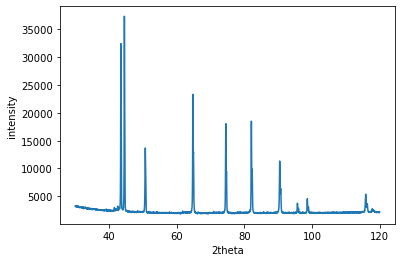

In [117]:
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.show()


## Add phases to the project

In [118]:
PhaseAustenite = gpx.add_phase(DataPathWrap("austenite-Duplex.cif"),
         phasename="Austenite",fmthint='CIF')

PhaseFerrite = gpx.add_phase(DataPathWrap("ferrite-Duplex.cif"),
         phasename="Ferrite",fmthint='CIF')

/Users/maxgarman/AusteniteCalculator/ExampleData/austenite-Duplex.cif read by Reader CIF
gpx file saved as /Users/maxgarman/AusteniteCalculator/SaveData/pkfit.gpx
/Users/maxgarman/AusteniteCalculator/ExampleData/ferrite-Duplex.cif read by Reader CIF
gpx file saved as /Users/maxgarman/AusteniteCalculator/SaveData/pkfit.gpx


In [119]:
## Guess locations for peaks based on lattice parameter

In [120]:
# Read the lattice parameter 
#a0_Austenite=PhaseAustenite.data['General']['Cell'][1]
#a0_Ferrite=PhaseFerrite.data['General']['Cell'][1]

# Fit values to check if the Peak Extraction has better luck
a0_Austenite=3.600
a0_Ferrite=2.8762

In [121]:
# Find the ka1 wavelength
# hist.data['Comments']

Ka1_wavelength=float([s for s in hist.data['Comments'] if s.startswith('Ka1')][0].split('=')[1])

# Hardcode for testing
#Ka1_wavelength=2.29092 # Cr wavelength for testing

# Calculate locations of peaks from .cif file



## Bragg diffraction
n * lambda=2 * d * sin(theta)

In [122]:
#hardcoding HKL lists for now, likely better ways to do this later...
HKL_BCC=[[1,1,0],[2,0,0],[2,1,1],[2,2,0],[3,1,0],[2,2,2],[3,2,1],[4,1,1]]
HKL_FCC=[[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0],[3,3,1],[4,2,0],[4,2,2]]

In [123]:
#for hkl in HKL_BCC:
#    d=(a0_Ferrite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]))   
    
d_BCC=[a0_Ferrite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]) for hkl in HKL_BCC]
SinTheta_BCC=[1*Ka1_wavelength/(2*d) for d in d_BCC]

d_FCC=[a0_Austenite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]) for hkl in HKL_FCC]
SinTheta_FCC=[1*Ka1_wavelength/(2*d) for d in d_FCC]

In [124]:
d_BCC

[2.0337805240487477,
 1.4381,
 1.1742037330321629,
 1.0168902620243738,
 0.9095343006176292,
 0.8302874221216008,
 0.768696783988515,
 0.6779268413495827]

In [125]:
# Create a list of 2Theta values from the dspacing and wavelength. Mark any non-physical values with np.nan
TwoTheta_BCC=[np.nan]*len(SinTheta_BCC)
for i,value in enumerate(SinTheta_BCC):
    #print(value)
    try:
        TwoTheta_BCC[i]=(2*math.degrees(math.asin(value)))
    except:
        TwoTheta_BCC[i]=(np.nan)
#print(TwoTheta_BCC)
#print(HKL_BCC)       
        
TwoTheta_FCC=[np.nan]*len(SinTheta_FCC)
for i,value in enumerate(SinTheta_FCC):
    #print(value)
    try:
        TwoTheta_FCC[i]=(2*math.degrees(math.asin(value)))
    except:
        TwoTheta_FCC[i]=(np.nan)
#print(TwoTheta_FCC)
#print(HKL_FCC)



In [126]:
# Create a list of TwoTheta in the data range
#print(max(hist.data['data'][1][0]))

TwoThetaInRange_BCC=[np.nan if i > max(hist.data['data'][1][0]) else i for i in TwoTheta_BCC]
TwoThetaInRange_BCC=[np.nan if i < min(hist.data['data'][1][0]) else i for i in TwoThetaInRange_BCC]

TwoThetaInRange_FCC=[np.nan if i > max(hist.data['data'][1][0]) else i for i in TwoTheta_FCC]
TwoThetaInRange_FCC=[np.nan if i < min(hist.data['data'][1][0]) else i for i in TwoThetaInRange_FCC]


#print(TwoTheta_FCC)
#print(TwoThetaInRange_FCC)



In [127]:
PeaksList=[]
PeaksList = np.array(TwoThetaInRange_BCC)[~np.isnan(np.array(TwoThetaInRange_BCC))]
PeaksList = np.concatenate((PeaksList,
                           np.array(TwoThetaInRange_FCC)[~np.isnan(np.array(TwoThetaInRange_FCC))]),
                           axis=0)
PeaksList=list(PeaksList)
# Don't sort, it actually makes keeping track of the different items harder...
# PeaksList.sort()

In [128]:
print(PeaksList)

[44.512834170653136, 64.77418924603545, 81.99379835803572, 98.48939129456159, 115.75557256664571, 43.50651939589083, 50.67428953446619, 74.4870534064565, 90.41527463400114, 95.67098491830755, 117.71590292777316]


In [129]:
#CIF is slightly off, kludge for now...
# Likely need to refine, adjust lattice parameters and start over again with peaks with non-negative intensities
# Or fix the negative intensities...
PeaksList=[x+0.5 for x in PeaksList]

In [130]:
# reset the peak list in case of errors...
hist.Peaks['peaks']=[]

## Start Fitting

In [131]:
# Add controls for number of cycles?

hist.set_refinements({'Background': {"no. coeffs": 5,'type': 'chebyschev-1', 'refine': True}})
hist.refine_peaks()

Number of function calls: 7 Number of observations: 3140 Number of parameters: 5
fitpeak time =    0.035s,    0.012s/cycle
Rwp =   34.25%, chi**2 =       940533, reduced chi**2 = 300.01
Background coefficients for chebyschev-1 function
value:   2358.63862  -324.96757   298.54077  -102.21858    74.60512
esd  :     18.76352    30.97063    29.62959    24.74965    24.56130


({'Back;0': 18.763518424198292,
  'Back;1': 30.970626765226825,
  'Back;2': 29.629591213457925,
  'Back;3': 24.749651164576715,
  'Back;4': 24.561297441179025},
 (array([2358.63861521, -324.96757161,  298.54076704, -102.21857721,
           74.60511932]),
  array([[ 1.1735244 , -0.20545698,  1.15333329, -0.10391783,  0.57912169],
         [-0.20545698,  3.197154  , -0.28853898,  1.37527663, -0.08905987],
         [ 1.15333329, -0.28853898,  2.92627332, -0.18693209,  1.26759655],
         [-0.10391783,  1.37527663, -0.18693209,  2.04174609, -0.13769551],
         [ 0.57912169, -0.08905987,  1.26759655, -0.13769551,  2.0107875 ]]),
  {'fvec': array([-1.63134087, -1.25567881, -0.38417849, ...,  3.21357246,
           4.01609119,  2.47074978]),
   'nfev': 7,
   'njev': 6,
   'fjac': array([[-1.18532501e+00,  1.48489515e-02,  1.49700174e-02, ...,
            1.81777323e-02,  1.83272403e-02,  1.80318245e-02],
          [ 1.06736706e-02,  8.31820270e-01,  2.05874272e-02, ...,
           -2.62

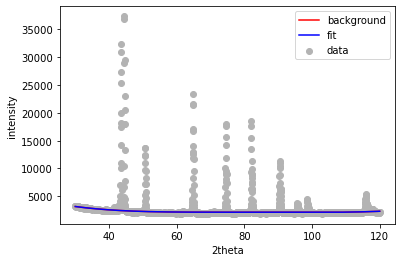

In [132]:
plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1], label='data', color='0.7')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][4], label='background', color='r')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3], label='fit', color='b')
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.legend()
plt.show()

## Add a few peaks to the list

- It seems like the peak positions are slightly off from the .cif file (about 0.4°)
- This results in negative intensities for some of the higher peaks
- Maybe look for maxima?  Or a series of fit sequences?
- Error check negative peaks?

In [133]:
#for peak in PeaksList[0:5]:
for peak in PeaksList:
    hist.add_peak(1, ttheta=peak)




In [134]:
# Need to use this order, otherwise fitting gets unstable
hist.set_peakFlags(area=True)
hist.refine_peaks()

# Resetting the value doesn't seem to work...
# for i,value in enumerate(hist.Peaks['peaks']):
#     print(value[2])
#     if value[2]<0:
#         print(hist.Peaks['peaks'][i][2],-value[2])
#         hist.Peaks['peaks'][i][2]=-value[2]
        
# hist.set_peakFlags(pos=True)
# hist.refine_peaks('hold')
        
hist.set_peakFlags(pos=True,area=True)
hist.refine_peaks()
hist.set_peakFlags(pos=True,area=True,sig=True)
hist.refine_peaks()

Number of function calls: 3 Number of observations: 3140 Number of parameters: 16
fitpeak time =    0.069s,    0.069s/cycle
Rwp =   34.10%, chi**2 =       932591, reduced chi**2 = 298.52
Background coefficients for chebyschev-1 function
value:   2336.65706  -351.32290   280.11559  -110.07137    60.98696
esd  :     19.89219    32.79286    31.81470    26.17842    25.87051
Peak coefficients:
                pos       esd       int       esd       sig       esd       gam       esd      bins  
 Peak1   :  45.01283               959.6    5650.8    18.500               4.157               4.36
 Peak2   :  65.27419              5271.4    6382.5    21.578               6.014               5.04
 Peak3   :  82.49380             14848.1    7487.0    25.020               7.984               5.78
 Peak4   :  98.98939             10649.9    8223.6    29.615              10.459               6.72
 Peak5   : 116.25557             39555.4   10890.0    37.116              14.181               8.14
 Peak6

({'Back;0': 6.286406497963487,
  'Back;1': 10.373980506718862,
  'Back;2': 10.03413821426792,
  'Back;3': 8.189982821936464,
  'Back;4': 8.056687836380199,
  'pos0': 0.0011291287431514803,
  'int0': 5333.683168816938,
  'sig0': 1.1081327826820813,
  'pos1': 0.0015566503119135771,
  'int1': 5323.674316385728,
  'sig1': 1.7300760392964771,
  'pos2': 0.0015226184983287963,
  'int2': 4870.273296978672,
  'sig2': 1.3706701573109787,
  'pos3': 0.00610403133776385,
  'int3': 3144.03311404934,
  'sig3': 6.374598956016044,
  'pos4': 0.00655672523005126,
  'int4': 4254.807427324087,
  'sig4': 11.23529917639017,
  'pos5': 0.0010045396639178229,
  'int5': 5679.41447930453,
  'sig5': 0.8859941795650389,
  'pos6': 0.20729947514458608,
  'int6': 1626.7181442434764,
  'sig6': 31.387337149517148,
  'pos7': 0.0016626279711562057,
  'int7': 4808.174431069862,
  'sig7': 1.5389834295241687,
  'pos8': 0.00289930222551057,
  'int8': 4582.139189145989,
  'sig8': 3.8131558801592744,
  'pos9': 0.247967762722858

In [135]:
#hist.set_peakFlags(area=True,pos=True,sig=True)

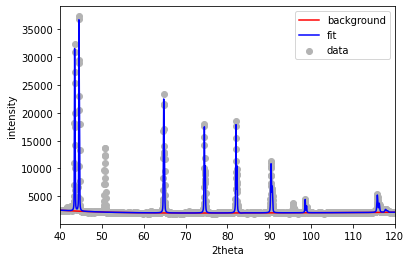

In [136]:

plt.xlim([40,120])

plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1], label='data', color='0.7')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][4], label='background', color='r')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3], label='fit', color='b')
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.legend()
plt.show()

In [104]:
type(hist)

GSASIIscriptable.G2PwdrData

In [105]:
hist.Peaks['peaks'][0][0]

69.0769425154267

In [106]:
for i,value in enumerate(hist.Peaks['peaks']):
    print(value[2])
    if value[2]<0:
        print(hist.Peaks['peaks'][i][2],-value[2])
        hist.Peaks['peaks'][i][2]=-value[2]
# hist.PeakList[0][0]=0
print(hist.PeakList)

-7330.789605912796
-7330.789605912796 7330.789605912796
-4715.071688844011
-4715.071688844011 4715.071688844011
-6809.962170197005
-6809.962170197005 6809.962170197005
-4118.794959845665
-4118.794959845665 4118.794959845665
[[69.0769425154267, 7330.789605912796, 54.69537239108769, 6.410539546837413], [106.09521678314687, 4715.071688844011, 147.29020920564562, 11.804628196916438], [67.38664215772212, 6809.962170197005, 64.65112664154506, 6.232012066323373], [79.55590608900027, 4118.794959845665, 68.52194413055517, 7.6124668534352615]]


In [107]:
for i,value in enumerate(hist.PeakList):
    print(value[1])
    if value[1]<0:
        print(hist.PeakList[i][1],-value[1])
        hist.PeakList[i][1]=-value[1]
hist.PeakList[0][0]=0
print(hist.PeakList)

7330.789605912796
4715.071688844011
6809.962170197005
4118.794959845665
[[69.0769425154267, 7330.789605912796, 54.69537239108769, 6.410539546837413], [106.09521678314687, 4715.071688844011, 147.29020920564562, 11.804628196916438], [67.38664215772212, 6809.962170197005, 64.65112664154506, 6.232012066323373], [79.55590608900027, 4118.794959845665, 68.52194413055517, 7.6124668534352615]]


### Recreate the lattice parameter a_0 from fit data
Added 2021 Apr 01 - AC


*We should probably work out data structures before too long*

In [34]:
#Find the hkls in range (may not be the ones fit, need to check)

#TwoThetaInRange_BCC
#HKL_BCC

#Merged with BCC, then FCC
hkl_list=[]
for i,row in enumerate(TwoThetaInRange_BCC):
    if np.isfinite(row):
        hkl_list.append(HKL_BCC[i])
for i,row in enumerate(TwoThetaInRange_FCC):
    if np.isfinite(row):
        hkl_list.append(HKL_FCC[i])
        
dspace_list=[]
for row in hkl_list:
    dspace_list.append(math.sqrt(row[0]*row[0]+row[1]*row[1]+row[2]*row[2]))

In [35]:
#hkl_list
dspace_list

[1.4142135623730951,
 2.0,
 2.449489742783178,
 2.8284271247461903,
 3.1622776601683795,
 1.7320508075688772,
 2.0,
 2.8284271247461903,
 3.3166247903554,
 3.4641016151377544,
 4.0]

In [36]:
# Read the 2theta position
hist.Peaks['peaks']
FitPos=[row[0] for row in hist.Peaks['peaks']] # only way to access column in list of lists

# Merge to determine the hkl


a0_list=[]
# probably should check if the lengths are the same
if len(FitPos) == len(dspace_list):
    for i,row in enumerate(FitPos):
        #row/2.0 since row is 2theta...
        a0_list.append((Ka1_wavelength*dspace_list[i])/(2*math.sin(math.radians(row/2.0))))
        print(row,math.sin(math.radians(row/2.0)),dspace_list[i],a0_list[i])
else:
    print("These are not the same length")

# 
#n * lambda=2 * d * sin(theta)
#Ka1_wavelength

#[2*math.sin(math.radians(row))* for row in FitPos]

#hist.Peaks['sigDict']

43.4742599676953 0.37034879510066937 1.4142135623730951 2.941463040500287
64.75712081581544 0.5355108171637917 2.0 2.87687559358636
82.03006742342863 0.656257032966677 2.449489742783178 2.875153186315563
98.56328512331973 0.7579253664325247 2.8284271247461903 2.874603070774555
115.81012989475248 0.847168893710896 3.1622776601683795 2.8753408410452272
44.5132368918583 0.37875552740893453 1.7320508075688772 3.522580948578457
51.340214982657216 0.4331889132543808 2.0 3.5564114243508285
74.46408254378565 0.6050444602938538 2.8284271247461903 3.6009495644447562
90.41458132978518 0.7096603927518479 3.3166247903554 3.600021623694204
83.13186263547986 0.6634814465799138 3.4641016151377544 4.021806523443756
117.77501695296695 0.8561544505773948 4.0 3.598878681202937


In [ ]:
# Looks like it does things in order, but not verified...
pos_keys=[key for key, value in hist.Peaks['sigDict'].items() if 'pos' in key]

FitPos_uncert=[]
for name in pos_keys:
    FitPos_uncert.append(hist.Peaks['sigDict'][name])

In [ ]:
# upper and lower bounds on uncertainties
a0_uncert_LB=[]
a0_uncert_UB=[]
if len(FitPos_uncert) == len(dspace_list):
    for i,row in enumerate(FitPos_uncert):
        #row/2.0 since row is 2theta...
        a0_uncert_UB.append((Ka1_wavelength*dspace_list[i])/(2*math.sin(math.radians((FitPos[i]+row)/2.0))))
        a0_uncert_LB.append((Ka1_wavelength*dspace_list[i])/(2*math.sin(math.radians((FitPos[i]-row)/2.0))))
        #print(row,math.sin(math.radians(row/2.0)),dspace_list[i],a0_list[i])
else:
    print("These are not the same length")

In [ ]:
print(a0_uncert_LB)

print(a0_list)

print(a0_uncert_UB)

In [ ]:
hist.Peaks['sigDict']

In [ ]:
a0_list

### Maybe fit entire pattern for lattice parameters, then try peakfitting?
- Seems like it works ok in the GUI, but need to allow the phase fraction to be refined (only on one)
- Add constraint, (austenite + ferrite  =1) 0:0:scale, 1:0:scale
- Need to refine both with the constraint enabled.  
- weight fracitons are quite different than the phase fractions (lattice cell dimensions?)
- Over estimation of the peak hights at first, then underestimate later
- austenite=3.60097, ferrite=2.87564
- Tried these parameters, had worse luck fitting...
- Maybe use the scale factor from the sample parameters to get the areas close?

In [ ]:
# Not working properly yet...

In [ ]:
# print('peak positions: ',[i[0] for i in hist.PeakList])
# for i in range(len(hist.Peaks['peaks'])):
#     print('peak',i,'pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])


In [ ]:
# for peak in PeaksList:
#     hist.add_peak(1, ttheta=peak)
# hist.set_peakFlags(area=True,pos=True,sig=True)


# pattern simulation, extract intensities from that?
https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#pattern-simulation

In [ ]:
gpx = G2sc.G2Project(newgpx=SaveWrap('Austenite-sim.gpx')) # create a project    

PhaseAustenite = gpx.add_phase(DataPathWrap("austenite-Duplex.cif"),
         phasename="Austenite",fmthint='CIF')

#PhaseFerrite = gpx.add_phase(DataPathWrap("ferrite-Duplex.cif"),
#         phasename="Ferrite",fmthint='CIF')

histogram_scale=100.

# add a simulated histogram and link it to the previous phase(s)
hist1 = gpx.add_simulated_powder_histogram("Austenite simulation",
            DataPathWrap('TestCalibration.instprm'),5.,120.,Npoints=5000,
            phases=gpx.phases(),scale=histogram_scale)
gpx.do_refinements()   # calculate pattern
gpx.save()

In [ ]:
plt.xlim([40,120])

plt.plot(hist1.data['data'][1][0], hist1.data['data'][1][1])
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.show()


### Theoretical intensities are included in the Reflection Lists
- see line ~817 in GSASIIobs.py for the full description of the reflection lists
columns 0,1,2: h,k,l
column 5: 2-theta
column 9: Calculated structure factor squared (inludes anamolous scattering and thermal parameters?)
column 11: Intensity correction (scales, polarization, preferred orientation, absorbtion, extinction)

It's not clear where thermal parameters or the unit cell volume come in.
Also not clear where 

In [ ]:
hist1.data

In [ ]:
hist1.data['Reflection Lists']['Austenite']['RefList'][0][11]

In [ ]:
hist1.data['Reflection Lists']['Austenite']['RefList'][:,9]

#### Array of the strucutre factors and intensity corrections (theoretical intensities?) for this material

In [ ]:
hist1.data['Reflection Lists']['Austenite']['RefList'][:,9] * hist1.data['Reflection Lists']['Austenite']['RefList'][:,11] / histogram_scale

In [ ]:
hist1.data['Reflection Lists']

In [ ]:
PhaseAustenite

In [ ]:
gpx = G2sc.G2Project(newgpx=SaveWrap('Ferrite-sim.gpx')) # create a project    

PhaseFerrite = gpx.add_phase(DataPathWrap("ferrite-Duplex.cif"),
         phasename="Ferrite",fmthint='CIF')

#PhaseFerrite = gpx.add_phase(DataPathWrap("ferrite-Duplex.cif"),
#         phasename="Ferrite",fmthint='CIF')

# add a simulated histogram and link it to the previous phase(s)
hist2 = gpx.add_simulated_powder_histogram("Ferrite simulation",
            DataPathWrap('TestCalibration.instprm'),5.,120.,Npoints=1000,
            phases=gpx.phases(),scale=500000.)
gpx.do_refinements()   # calculate pattern
gpx.save()

## Used the GUI to investigate this data a bit more.  
- Peakfits like I did above seem to work ok.  
- Values of integrated intensity are closest to the I100 column of the reflection lists
- Intensities and F values between this and the magic spreadsheet don't agree
- Compositions are slightly different. Only wt% used in magic spreadsheet.

In [ ]:
### Have not edited below this for austenite calculator

In [ ]:
dlist=[2.0923, 2.0923-0.05, 2.0923+0.05]
TOFlist=[]
for i in dlist:
    print(TOF_calc(i,16324.50,6.86,0.00))
    TOFlist.append(TOF_calc(i,16324.50,6.86,0.00))

In [ ]:


plt.xlim(TOFlist[1],TOFlist[2])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.show()

In [ ]:
def OutputData(hist, append, Tick, LowLimit, HighLimit):
    # plot fit and difference
    plt.figure(figsize=[10,8])
    plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],'-o',color='g',label='Difference')
    # vertical line for place of intial guess
    plt.vlines(Tick,0,plt.gca().get_ylim()[0]*0.5)
    # horizontal line to benchmark difference plot
    plt.hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],'0.7')
    plt.xlim(LowLimit, HighLimit)
    plt.legend()
    # option to view on screen
    #plt.show()
    # option to save the plot
    plt.savefig("GSASPeakFit-"+append+".png", dpi=300)

    keys = hist.Peaks['sigDict'].keys()
    #print(keys)
    with open("GSASPeakFit-"+append+".csv",'a') as fd:
        wr=csv.writer(fd)
        dwr=csv.DictWriter(fd, keys)

        wr.writerow(['# TOF position (pos)', 'Area (int)','Alpha (alp)','Beta (bet)','Sigma (sig)','Gamma (gam)'])
        wr.writerow(['# Peak Parameter List'])
        wr.writerow(['# Peak Parameter Flags'])
        wr.writerow(hist.Peaks['peaks'][0][0::2])
        wr.writerow(hist.Peaks['peaks'][0][1::2])
        wr.writerow(["########################"])
        wr.writerow(['# Background Values'])
        wr.writerow(hist['Background'][0][3:])
        wr.writerow(["########################"])
        wr.writerow(['# SigDict Keys'])
        wr.writerow(['# SigDict Values'])
        dwr.writeheader()
        dwr.writerows([hist.Peaks['sigDict']])
        wr.writerow(["########################"])
        wr.writerow(['# Covariance Matrix'])
        wr.writerows(np.array(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Correlation Matrix'])
        wr.writerows(np.corrcoef(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Reduced ChiSq (GOF)'])
        wr.writerow([hist.data['Peak Fit Rvals']['GOF']])
        wr.writerow(["########################"])   
        wr.writerow(['# Dspacing (1 term) -/+ (3 terms)'])
        try:
            d=Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)
            d_minus=Dspace_calc(hist.Peaks['peaks'][0][0]-hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            d_plus=Dspace_calc(hist.Peaks['peaks'][0][0]+hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            wr.writerow([d,d_minus,d_plus])
            wr.writerow([d,d-d_minus,d_plus-d])
        except:
            wr.writerow([Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)])             
    fd.close()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print(i)

In [ ]:
hist['Background'][0][3:]

In [ ]:
hist.Peaks['peaks'][0][0::2]

In [ ]:
hist.Peaks['sigDict']

In [ ]:
#OutputData(hist, "", TOFlist[0],TOFlist[1],TOFlist[2])
# Doesn't work well prior to fitting

# Sequence 1, following Rawplot method

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 2,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq1)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, gam=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step5-Gam",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, gam=0)
hist.refine_peaks()
OutputData(hist, "Seq1-Step6-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


# Sequence 2 (Single background; alpha and beta refined, not gamma)

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 1,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq2)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, alp=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step5-Alp",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(alp=0, bet=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step6-Bet",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, bet=0)
hist.refine_peaks()
OutputData(hist, "Seq2-Step7-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


In [ ]:
gpx.get_Covariance(['0:0:Back;0','0:0:Back;1','0:0:pos0','0:0:int0','sig0'])

In [ ]:
hist.keys()

In [ ]:
hist['Background']

In [ ]:
hist['Peak Fit Result'][1]

In [ ]:
np.corrcoef(hist['Peak Fit Result'][1])

# Nothing run below this

In [ ]:
hist.Peaks['sigDict']

In [ ]:
hist.data

In [ ]:
if 'C' in hist.data['Instrument Parameters'][0]['Type'][0]:
    print("hi")
else:
    print("low")

In [ ]:
hist.data['Peak Fit Rvals']['GOF']

In [ ]:
hist.set_peakFlags(area=True, pos=True, sig=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, gam=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, sig=True, gam=True)
hist.refine_peaks()

In [ ]:
print('peak positions: ',[i[0] for i in hist.PeakList])
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i,'pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])


In [ ]:
hist.Peaks['sigDict']

In [ ]:
# fit peaks
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],label='Computed Intensity')
plt.xlim(11752.,40000.)
plt.show()

In [ ]:
# fit difference
plt.figure(figsize=[10,8])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],color='g',label='Difference')
plt.xlim(11752.,40000.)
plt.legend()
plt.show()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i)
    print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    print('Dspace pos=', Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (pos)=',Dspace_calc(hist.Peaks['peaks'][i][0]+hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (neg)=',Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0]-hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00))
    
    

In [ ]:
print(hist.Peaks)

## From GSASIIscriptable.py, lines 4007

        :returns: dict with two elements where item
          'peaks' is a list of peaks where each element is 
          [pos,pos-ref,area,area-ref,sig,sig-ref,gam,gam-ref], 
          where the -ref items are refinement flags and item
          'sigDict' is a dict with possible items 'Back;#', 
          'pos#', 'int#', 'sig#', 'gam#'
          
Fitting output lists:pos       esd       int       esd      alp     esd     bet     esd      sig       esd       gam       esd      bins

The fitting output values correspond to the column values

In [ ]:
#print(hist.Peaks)
HistDF=pd.DataFrame(hist.Peaks['peaks'], columns=['pos','pos-ref','area','area-ref','alph',
                                                  'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                                  'Gam','gam-ref'])
print(HistDF)

In [ ]:
print(hist.Peaks['sigDict'])

In [ ]:
SigDF=pd.DataFrame(hist.Peaks['sigDict'])#, columns=['pos','pos-ref','area','area-ref','alph',
                                            #      'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                            #      'Gam','gam-ref'])
print(SigDF)

In [ ]:
DataList=[]
for i in range(len(hist.Peaks['peaks'])):
    #print('peak',i)
    #print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    DataList.append([i,hist.Peaks['peaks'][i][0],hist.Peaks['sigDict']['pos'+str(i)]])
#print(DataList)
ListDF=pd.DataFrame(DataList, columns=['Peak index','TOF Pos','TOF esd'])

#ListDF['Dspace Pos']=Dspace_calc(ListDF['TOF Pos'],16324.50,6.86,0.00)
ListDF['Dspace Pos']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
ListDF['Dspace esd']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos']+x['TOF esd'],16324.50,6.86,0.00) - 
                                      Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
print(ListDF)
ListDF.to_csv('GSASPeakFit.csv')

In [ ]:
##  See further down on sequential refinements
# Sequential Refinement

# gpx.set_Controls('cycles',10)